# CosmoDC realizations
## Dependencies

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import GCRCatalogs
from GCR import GCRQuery

## Data
Load flexzboost the catalog

In [3]:
%%time
cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small_with_photozs_flexzboost_v1")

CPU times: user 1.3 s, sys: 3.96 s, total: 5.26 s
Wall time: 54.8 s


In [4]:
data = cat.get_quantities(['photoz_mask','photoz_pdf','photoz_mean','photoz_mode','photoz_odds','photoz_mode_ml_red_chi2','mag_i_lsst','mag_i_photoz','redshift'],
                           native_filters=['healpix_pixel==9816'])

In [5]:
fz_redshift = data['redshift']
fz_photoz_mask = data['photoz_mask']
fz_photoz_mode = data['photoz_mode']
fz_mag_i_photoz = data['mag_i_photoz']
print(len(fz_redshift))
print(len(fz_photoz_mode))
fz_redshift = fz_redshift[fz_photoz_mask]
fz_mag_i_photoz = fz_mag_i_photoz[fz_photoz_mask]
print(len(fz_redshift))

17261509
1628434
1628434


In [6]:
pzdict = {'specz':fz_redshift,'zmode':fz_photoz_mode,'zmean':data['photoz_mean'],'odds':data['photoz_odds'],'ml_chi2':data['photoz_mode_ml_red_chi2'],
          'mag_i_photoz':fz_mag_i_photoz}
fz_df = pd.DataFrame(pzdict)
fz_df['pdf']=list(data['photoz_pdf'])

magcut = 23.6
brightmask = (fz_df['mag_i_photoz']<magcut)
fz_df = fz_df[brightmask]

zgrid = cat.photoz_pdf_bin_centers

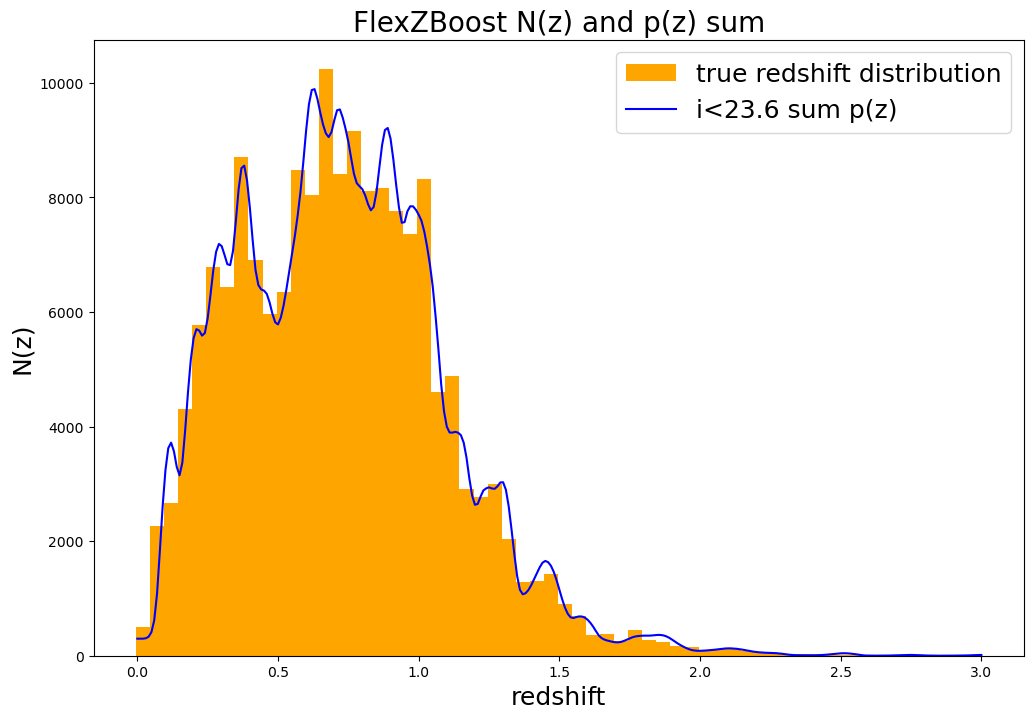

In [7]:
fig = plt.figure(figsize=(12,8))
nzsum = np.sum(fz_df['pdf'])
szbins = np.arange(-0.005,3.005,0.05)
plt.hist(fz_df['specz'],bins=szbins,color='orange',label='true redshift distribution')
plt.plot(zgrid,.05*nzsum,c='b',label=f"i<{magcut} sum p(z)")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.title("FlexZBoost N(z) and p(z) sum",fontsize=20)
plt.legend(loc = 'upper right',fontsize=18);

## Make Tomographic bins

In [44]:
tomocut_1 = ((fz_df['zmode']>0.1) & (fz_df['zmode']<=0.4))
tomocut_2 = ((fz_df['zmode']>0.4) & (fz_df['zmode']<=0.8))
tomocut_3 = ((fz_df['zmode']>0.8) & (fz_df['zmode']<=1.2))
tomocut_4 = ((fz_df['zmode']>1.2) & (fz_df['zmode']<=1.6))

print("Make fiducial photo-z")
bin_1_photo_pdf = np.array(fz_df['pdf'][tomocut_1])
bin_2_photo_pdf = np.array(fz_df['pdf'][tomocut_2])
bin_3_photo_pdf = np.array(fz_df['pdf'][tomocut_3])
bin_4_photo_pdf = np.array(fz_df['pdf'][tomocut_4])
bin_1_photo_fid = np.sum(bin_1_photo_pdf) / np.sum(np.sum(bin_1_photo_pdf))
bin_2_photo_fid = np.sum(bin_2_photo_pdf) / np.sum(np.sum(bin_2_photo_pdf))
bin_3_photo_fid = np.sum(bin_3_photo_pdf) / np.sum(np.sum(bin_3_photo_pdf))
bin_4_photo_fid = np.sum(bin_4_photo_pdf) / np.sum(np.sum(bin_4_photo_pdf))

print("Generate photo-z dists")
bin_1_photo_norms = np.array([np.sum(pdf) for pdf in bin_1_photo_pdf])
bin_2_photo_norms = np.array([np.sum(pdf) for pdf in bin_2_photo_pdf])
bin_3_photo_norms = np.array([np.sum(pdf) for pdf in bin_3_photo_pdf])
bin_4_photo_norms = np.array([np.sum(pdf) for pdf in bin_4_photo_pdf])
bin_1_photo_pdf = bin_1_photo_pdf/bin_1_photo_norms
bin_2_photo_pdf = bin_2_photo_pdf/bin_2_photo_norms
bin_3_photo_pdf = bin_3_photo_pdf/bin_3_photo_norms
bin_4_photo_pdf = bin_4_photo_pdf/bin_4_photo_norms
bin_1_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_1_photo_pdf])
bin_2_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_2_photo_pdf])
bin_3_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_3_photo_pdf])
bin_4_photo_cdf = np.array([np.cumsum(pdf) for pdf in bin_4_photo_pdf])

print("Generate cdf interpolators")
bin_1_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_1_photo_cdf])
bin_2_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_2_photo_cdf])
bin_3_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_3_photo_cdf])
bin_4_photo_cdf_i = np.array([scipy.interpolate.interp1d(cdf, zgrid, fill_value="extrapolate") for cdf in bin_4_photo_cdf])

print("Generate samples from interpolators")
rs = np.array([np.random.uniform() for i in np.arange(1_000)])
bin_1_photo_samples = np.array([cdf(rs) for cdf in bin_1_photo_cdf_i])
bin_2_photo_samples = np.array([cdf(rs) for cdf in bin_2_photo_cdf_i])
bin_3_photo_samples = np.array([cdf(rs) for cdf in bin_3_photo_cdf_i])
bin_4_photo_samples = np.array([cdf(rs) for cdf in bin_4_photo_cdf_i])

print("Make histograms out of samples")
zbins_1 = np.arange(0.,0.6, 0.02)
znodes_1 = 0.5*(zbins_1[1:]+zbins_1[:-1])
bin_1_photo_hists = np.array([np.histogram(samples, bins=zbins_1, density=True)[0] for samples in bin_1_photo_samples.T])
bin_1_photo_hists_norms = np.array([np.sum(hist) for hist in bin_1_photo_hists])
bin_1_photo_hists = bin_1_photo_hists.T/bin_1_photo_hists_norms
zbins_2 = np.arange(0.3, 0.9, 0.02)
znodes_2 = 0.5*(zbins_2[1:]+zbins_2[:-1])
bin_2_photo_hists = np.array([np.histogram(samples, bins=zbins_2, density=True)[0] for samples in bin_2_photo_samples.T])
bin_2_photo_hists_norms = np.array([np.sum(hist) for hist in bin_2_photo_hists])
bin_2_photo_hists = bin_2_photo_hists.T/bin_2_photo_hists_norms
zbins_3 = np.arange(0.7, 1.3, 0.02)
znodes_3 = 0.5*(zbins_3[1:]+zbins_3[:-1])
bin_3_photo_hists = np.array([np.histogram(samples, bins=zbins_3, density=True)[0] for samples in bin_3_photo_samples.T])
bin_3_photo_hists_norms = np.array([np.sum(hist) for hist in bin_3_photo_hists])
bin_3_photo_hists = bin_3_photo_hists.T/bin_3_photo_hists_norms
zbins_4 = np.arange(1.1, 1.7, 0.02)
znodes_4 = 0.5*(zbins_4[1:]+zbins_4[:-1])
bin_4_photo_hists = np.array([np.histogram(samples, bins=zbins_4, density=True)[0] for samples in bin_4_photo_samples.T])
bin_4_photo_hists_norms = np.array([np.sum(hist) for hist in bin_4_photo_hists])
bin_4_photo_hists = bin_4_photo_hists.T/bin_4_photo_hists_norms

print("Generate spectrographic dists")
zbins = np.arange(0.,3.01,0.02)
znodes = 0.5*(zbins[1:]+zbins[:-1])
bin_1_spec = fz_df['specz'][tomocut_1]
bin_1_spec_hist = np.histogram(bin_1_spec, bins=zbins, density=True)[0]
bin_1_spec_hist = bin_1_spec_hist/np.sum(bin_1_spec_hist)
bin_2_spec = fz_df['specz'][tomocut_2]
bin_2_spec_hist = np.histogram(bin_2_spec, bins=zbins, density=True)[0]
bin_2_spec_hist = bin_2_spec_hist/np.sum(bin_2_spec_hist)
bin_3_spec = fz_df['specz'][tomocut_3]
bin_3_spec_hist = np.histogram(bin_3_spec, bins=zbins, density=True)[0]
bin_3_spec_hist = bin_3_spec_hist/np.sum(bin_3_spec_hist)
bin_4_spec = fz_df['specz'][tomocut_4]
bin_4_spec_hist = np.histogram(bin_4_spec, bins=zbins, density=True)[0]
bin_4_spec_hist = bin_4_spec_hist/np.sum(bin_4_spec_hist)

Make fiducial photo-z
Generate photo-z dists
Generate cdf interpolators
Generate samples from interpolators
Make histograms out of samples
Generate spectrographic dists


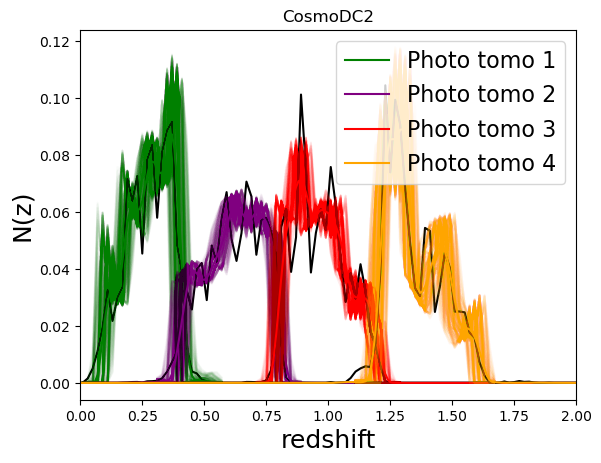

In [45]:
#fig = plt.figure(figsize=(15,8))

plt.plot(znodes, bin_1_spec_hist, 'k-')
plt.plot(znodes_1, bin_1_photo_hists, 'g-', alpha=0.01)
plt.plot(zgrid, 2.*bin_1_photo_fid, 'g-',label='Photo tomo 1')

plt.plot(znodes, bin_2_spec_hist, 'k-')
plt.plot(znodes_2, bin_2_photo_hists, '-', color='purple', alpha=0.01)
plt.plot(zgrid, 2*bin_2_photo_fid, '-', color='purple', label='Photo tomo 2')

plt.plot(znodes, bin_3_spec_hist, 'k-')
plt.plot(znodes_3, bin_3_photo_hists, 'r-', alpha=0.01)
plt.plot(zgrid, 2*bin_3_photo_fid, 'r-',label='Photo tomo 3')

plt.plot(znodes, bin_4_spec_hist, 'k-')
plt.plot(znodes_4, bin_4_photo_hists, '-', color='orange', alpha=0.01)
plt.plot(zgrid, 2.*bin_4_photo_fid, '-', color='orange', label='Photo tomo 4')

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 2.0])
plt.title("CosmoDC2")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);
plt.show()

In [10]:
cosmodc2_nzs = {}
cosmodc2_nzs['bin_1'] = bin_1_photo_hists
cosmodc2_nzs['bin_2'] = bin_2_photo_hists
cosmodc2_nzs['bin_3'] = bin_3_photo_hists
cosmodc2_nzs['bin_4'] = bin_4_photo_hists

cosmodc2_nzs['z1'] = znodes_1
cosmodc2_nzs['z2'] = znodes_2
cosmodc2_nzs['z3'] = znodes_3
cosmodc2_nzs['z4'] = znodes_4

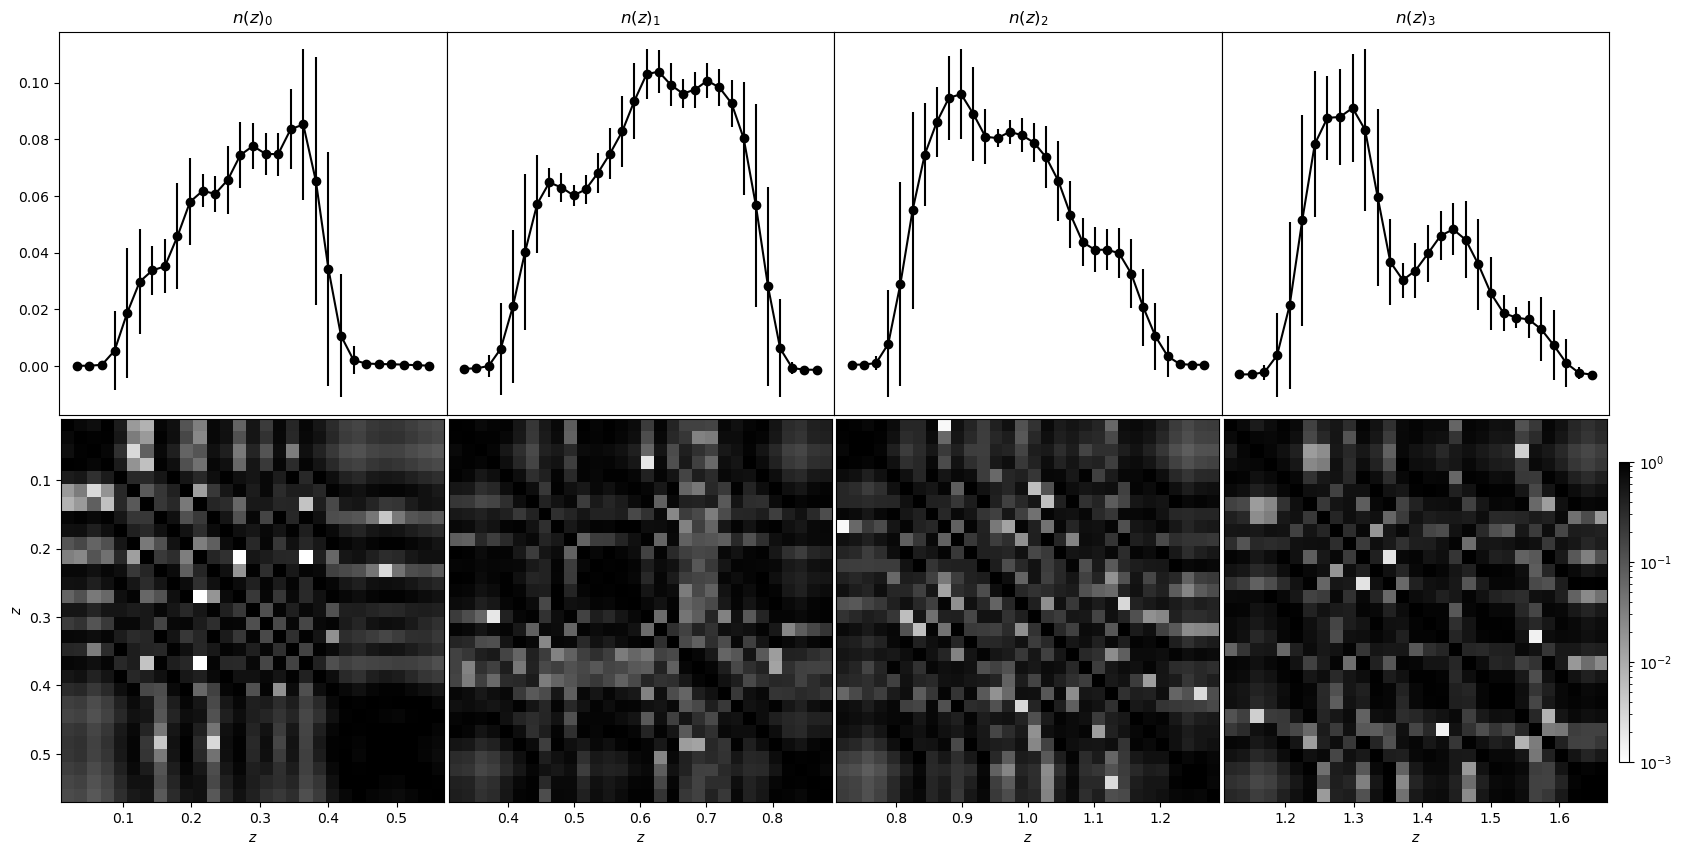

In [31]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
keys = ['bin_1', 'bin_2', 'bin_3', 'bin_4']
for name in keys:
    nzs = np.array(cosmodc2_nzs[name])
    zs = np.array(cosmodc2_nzs['z{}'.format(i+1)])
    m = np.mean(nzs, axis=1)
    s = np.std(nzs, axis=1)
    cov = np.cov(nzs)
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(zs, m, yerr=err,
                        fmt='{}o-'.format(colorss[i]),
                        label="$CosmoDC2_{}$".format(i))
    #axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$n(z)_{}$".format(i))
    axis[0, i].set_xticks([])
    im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                        extent=[min(zs), max(zs), max(zs), min(zs)])
    axis[1, i].set_xlabel(r"$z$")
    if i > 0:
        axis[0, i].set_yticks([])
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()

In [32]:
from numpy.linalg import eig, cholesky
def get_chol(cov):
    if not np.all(np.linalg.eigvals(cov) > 0):
        print('Warning: Covariance matrix is not positive definite')
        print('The covariance matrix will be regularized')
        jitter = 1e-15 * np.eye(cov.shape[0])
        w, v = eig(cov+jitter)
        w = np.real(np.abs(w))
        v = np.real(v)
        cov = v @ np.diag(np.abs(w)) @ v.T
        cov = np.tril(cov) + np.triu(cov.T, 1)
        if not np.all(np.linalg.eigvals(cov) > 0):
            print('Warning: regularization failed')
            print('The covariance matrix will be diagonalized')
            cov = np.diag(np.diag(cov))
    chol = cholesky(cov)
    return cov, chol

In [33]:
covv_1, _ = get_chol(cov_1)
err = np.sqrt(np.diag(covv_1))
corr = cov / (np.outer(err, err))

The covariance matrix will be regularized


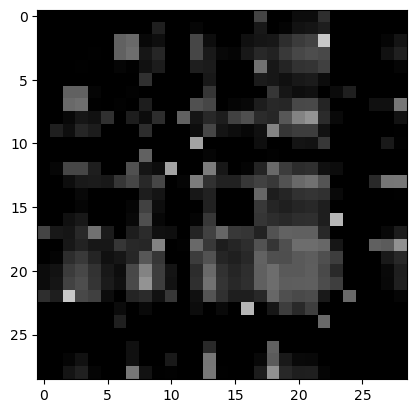

In [29]:
plt.imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1))